# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])
#plt.rc('text', usetex=True)

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/plots/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [114]:
import plot_baselines

jitter = 1e-5
filters_dict = plot_baselines.spike_history_filters(rng, prng_state, jitter, array_type)

In [115]:
a, c = 6., 30.
phi_lower, phi_upper = a * np.log(c) - np.pi, (a * np.log(500 + c) + np.pi) * 0.87
print(phi_lower, phi_upper)

17.26559163638314 35.47760358279412


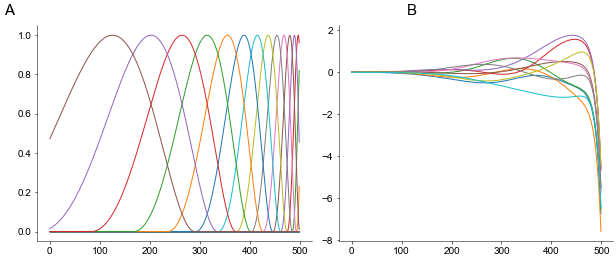

In [116]:
fig = plt.figure(figsize=(8, 3))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.65, 1.05, 'B', fontsize=15, ha='center')



widths = [1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

filter_t = filters_dict["glm_filter"]
t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])


ax = fig.add_subplot(spec[0, 1])

filter_t = filters_dict["gp_filter"]
t = np.arange(filter_t.shape[1])

tr = 2
ax.plot(t, filter_t[:, :, 1, 0].T)



plt.show()

### Schematic of model

In [3]:
import plot_schematic

In [8]:
evalsteps = 10000
L = 100.

evals, spiketimes, pos_sample, ISIs, tISI, tuISIs, tau, tau_tilde = plot_schematic.model_inputs(
    prng_state, evalsteps, L)


num_samps = 10
evalsteps = 500
L = 3.0

cisi_t_eval, ISI_densities, cisi_tau_tilde, log_rho_tildes = plot_schematic.BNPP_samples(
    prng_state, rng, num_samps, evalsteps, L)

In [ ]:
B
# a.u. tau, s for t, show the absolute numbers on time
# label for histogram
C
# log lambda -> log rho

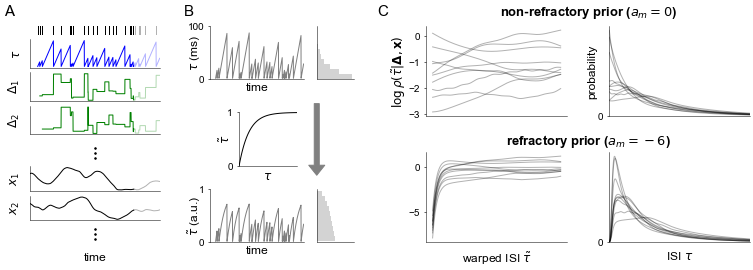

In [21]:
fig = plt.figure(figsize=(10, 3))
fig.text(-0.03, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.22, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.49, 1.05, 'C', fontsize=15, ha='center')



T = 800
Te = 1000


widths = [1]
heights = [0.3, 1, 1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.18, wspace=0.1)


ax = fig.add_subplot(spec[0, 0])
spkts = spiketimes[spiketimes < T]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k')
    spkts = spiketimes[(T <= spiketimes) & (spiketimes < Te)]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k', alpha=0.3)
ax.set_xlim([evals[0], evals[Te]])
ax.set_ylim([0, 1])
ax.axis('off')


ax = fig.add_subplot(spec[1, 0])

ax.plot(evals[:T], ISIs[:T, 0, 0], c='b')
ax.plot(evals[T:Te], ISIs[T:Te, 0, 0], c='b', alpha=0.3)
ax.set_xlim([evals[0], evals[Te]])
ax.set_ylabel(r'$\tau$')
ax.set_yticks([])
ax.set_xticks([])


for k in range(2):
    ax = fig.add_subplot(spec[k + 2, 0])
    ax.plot(evals[:T], ISIs[:T, 0, k+1], c='g')
    ax.plot(evals[T:Te], ISIs[T:Te, 0, k+1], c='g', alpha=0.3)
    ax.set_xlim([evals[0], evals[Te]])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel('$\Delta_{}$'.format(k+1))

    
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.475, bottom=0.375, 
                        left=0.0, right=0.18, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')
    

widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.35, bottom=0.1, 
                        left=0.0, right=0.18, wspace=0.0)

for d in range(2):
    ax = fig.add_subplot(spec[d, 0])
    ax.plot(evals[:T], pos_sample[0, :T, d, 0], c='k')
    ax.plot(evals[T:Te], pos_sample[0, T:Te, d, 0], alpha=0.3, c='k')
    ax.set_xlim([evals[0], evals[Te]])
    ax.set_ylabel('$x_{}$'.format(d+1))
    ax.set_xticks([])
    ax.set_yticks([])
    
ax.set_xlabel('time', labelpad=32)


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.1, bottom=0.0, 
                        left=0.0, right=0.18, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')



### time warping ###
widths = [1, 0.4]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.25, right=0.45, hspace=2.1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(evals[:Te], ISIs[:Te, 0, 0] * 1e3, c='gray')
ax.set_xticks([])
ax.set_xlim([evals[0], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tau$ (ms)', labelpad=-14)
ax.set_ylim([0, 100])
ax.set_yticks([0, 100])

ax = fig.add_subplot(spec[0, 1])
ax.hist(ISIs[:, 0, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0)


ax = fig.add_subplot(spec[1, 0])
ax.plot(evals[:Te], tISI[:Te, 0], c='gray')
ax.set_xticks([])
ax.set_xlim([evals[0], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$ (a.u.)', labelpad=-4)
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])

ax = fig.add_subplot(spec[1, 1])
ax.hist(tISI[:, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([0, 1])
ax.set_xlim([0, 3])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.6, bottom=0.35, 
                        left=0.29, right=0.37)

ax = fig.add_subplot(spec[0, 0])
ax.plot(tau[:, 0], tau_tilde[:, 0], c='k')
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.set_xlim([tau[0, 0], tau[-1, 0]])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$\tau$', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$', labelpad=-5)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)


### log intensity and ISI ###
n = 0
f_dim = 0

widths = [1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.55, right=1.0, hspace=0.4, wspace=0.3)

fig.text(0.775, 1.05, r'non-refractory prior ($a_m = 0$)', fontsize=13, 
         fontweight='bold', ha='center')
fig.text(0.775, 0.45, r'refractory prior ($a_m = -6$)', fontsize=13, 
         fontweight='bold', ha='center')

ax = fig.add_subplot(spec[0, 0])
ax.plot(cisi_tau_tilde, log_rho_tildes[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_ylabel(r'$\log \rho(\tilde{\tau}|\mathbf{\Delta}, \mathbf{x})$', labelpad=1)

ax = fig.add_subplot(spec[1, 0])
ax.plot(cisi_tau_tilde, log_rho_tildes[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel(r'warped ISI $\tilde{\tau}$')

ax = fig.add_subplot(spec[0, 1])
ax.plot(cisi_t_eval, ISI_densities[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([0])
ax.set_ylabel('probability', labelpad=1)
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)

ax = fig.add_subplot(spec[1, 1])
ax.plot(cisi_t_eval, ISI_densities[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([0])
ax.set_xlabel(r'ISI $\tau$')
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)



#plt.savefig('../saves/schematic.pdf')
plt.show()

In [83]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.2, 100.5, neurons)
        renewal = lib.likelihoods.GammaRenewal(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.LogNormalRenewal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(1.0, 1.5, neurons)
        renewal = lib.likelihoods.InverseGaussianRenewal(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = lib.likelihoods.ExponentialRenewal(
            neurons,
            dt,
        )
    
    return renewal

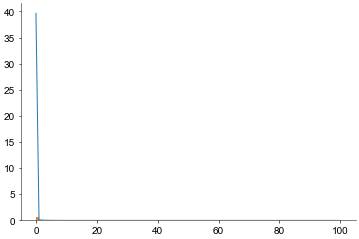

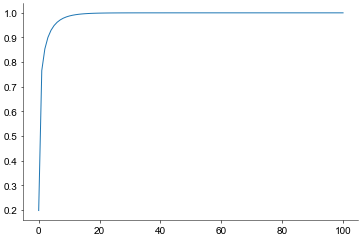

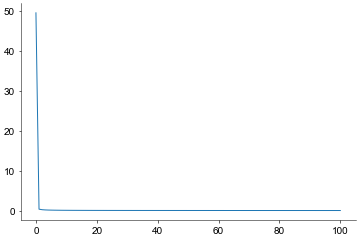

In [84]:
dt = 0.001
rm = get_renewal('gamma', 1, dt)

mc = 1000
samples = jax.vmap(rm.sample_ISI)(jr.split(prng_state, mc))


ISI = jnp.linspace(0.001, 100., 100)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(ISI, np.exp(ll)[:, :])
plt.hist(np.array(samples)[:, -1], bins=np.array(ISI)[:, 0], density=True)
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(ISI, cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(ISI, jnp.exp(lh[:, :]))
plt.show()

NameError: name 'an_pos' is not defined

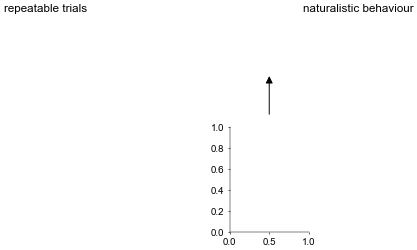

In [85]:
fig = plt.figure(figsize=(8, 3))

fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


    
### behaviour ###


# position
tps = [300, 1000, 1700]
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    tp = tps[k]

    x = an_pos[0, 0, tp]
    y = an_pos[0, 1, tp]
    dx = (an_pos[0, 0, tp+1]-an_pos[0, 0, tp])*100
    dy = (an_pos[0, 1, tp+1]-an_pos[0, 1, tp])*100

    ax.scatter(x, y, marker='o', facecolor='k', s=40)
    #ax.arrow(x, y, dx, dy)
    ax.plot(an_pos[0, 0, :tp], an_pos[0, 1, :tp], c='k')
    ax.plot(an_pos[0, 0, tp:], an_pos[0, 1, tp:], c='lightgray')
    ylims = ax.get_ylim()
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_aspect(1.)
    utils.plot.decorate_ax(ax)
            
            
plt.savefig('output/comparison.pdf')
plt.show()

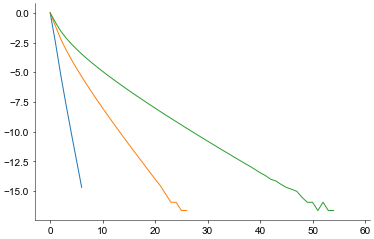

In [77]:
from tensorflow_probability.substrates import jax as tfp

igd = tfp.distributions.InverseGaussian(jnp.linspace(0.5, 1.5, 3), jnp.ones(3))

t = jnp.linspace(0.001, 100., 100)[:, None]
lh = igd.log_survival_function(t)

plt.plot((lh[:, :]))
plt.show()